## metapath2vec和deepwalk模型结果比较
**参考资料：**
* [代码参考地址](https://github.com/czy1999/Graph-Embedding-JUST)

In [41]:
import numpy as np
import pandas  as pd
import networkx as nx
import random
import gensim
from gensim.models import Word2Vec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn import manifold
import matplotlib.pyplot as plt

method = 'Metapath2vec'
method2 = 'DeepWalk'
database = 'dblp'

In [42]:
# Load data
def get_moive_data():
    label = pd.read_csv('Datasets/movie/movie_labels.txt',sep ='\t',header = None)
    del label[6]
    label['id'] = label[0].apply(lambda x:'m'+str(x))
    del label[0]
    label = label.set_index('id')
    l = []
    for i in label.index:
        l.append(label.loc[i].tolist())
    label['label'] = l
    label = label.reset_index()
    data = label[['id','label']]
    data = data[data['id'].apply(lambda x: x in model.key_to_index.keys())]
    data['vector'] = data['id'].apply(lambda x:model[x])
    return data

def get_dblp_data():
    label = pd.read_csv('Datasets/DBLP/dblp_labels.txt',sep ='\t')
    label['label'] = 0
    for i,v in enumerate(label):
        if i!=0 and v!='label':
            label['label'] += i*label[v] 
    # label['label'] = label['database'] + 2*label['data mining']+3*label['machine learning']+ 4*label['information retrieval']
    label = label[label['author_id'].apply(lambda x: x in  model.key_to_index.keys())]
    label['vector'] = label['author_id'].apply(lambda x: model[x])
    data = label[['author_id','vector','label']].copy()
    data.loc[:,'id'] = data.loc[:,'author_id']
    del data['author_id']
    return data

def get_Foursquare_data():
    label = pd.read_csv('Datasets/Foursquare/Foursquare_labels.txt',sep =',',header = None)
    label['id'] = label[0]
    d = {}
    for i,v in enumerate(label[1].unique()):
        d[v] = i
    label['label'] = label[1].apply(lambda x:d[x])
    label = label[label['id'].apply(lambda x: x in model.key_to_index.keys())]
    label['vector'] = label['id'].apply(lambda x:model[x])
    data = label[['id','label','vector']]
    return data

def get_data(d):
    if d == 'dblp':
        return get_dblp_data()
    elif d == 'movie':
        return get_moive_data()
    elif d == 'Foursquare':
        return get_Foursquare_data()


In [43]:
model = gensim.models.KeyedVectors.load_word2vec_format('Vectorfile/'+method+'/'+database+'.embeddings')
data = get_data(database)
data

,vector,label,id
0,"[0.9992793, 0.28577366, -1.0558357, -0.2872979...",3,a1
1,"[0.3854714, -0.06289876, -0.105725065, 0.04726...",3,a5
2,"[0.2544724, 0.08393872, -0.20412554, -0.149748...",3,a8
3,"[0.9370148, -0.108122565, -0.17455548, -0.1144...",3,a9
4,"[0.15638436, -0.0038674353, -0.21932548, 0.003...",3,a10
...,...,...,...
1904,"[0.33794087, -0.006902423, -0.061611082, 0.247...",4,a10054
1905,"[0.05211385, -0.10007657, 0.11593047, 0.074047...",4,a10090
1906,"[0.093751214, -0.08660853, 0.16750973, 0.20219...",3,a10104
1907,"[-0.080834985, -0.10058027, 0.09629447, 0.0896...",3,a10124


# 向量分布展示

In [44]:
np.array(data.vector.tolist()).shape

(1909, 128)

In [45]:
# reduce dimensions to 2
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
result = tsne.fit_transform(np.array(data.vector.tolist()))

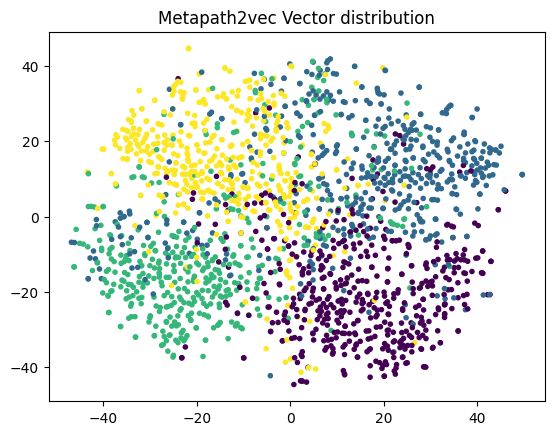

In [46]:
from sklearn.decomposition import PCA
def plot_nodes(data, method1):
    data.loc[:,'x'] = result[:, 0] 
    data.loc[:,'y'] = result[:, 1]
    #plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.title(method1 +' Vector distribution')
    plt.scatter(data['x'],data['y'],c=data['label'],marker=".")
    plt.show()
plot_nodes(data.copy(), method)

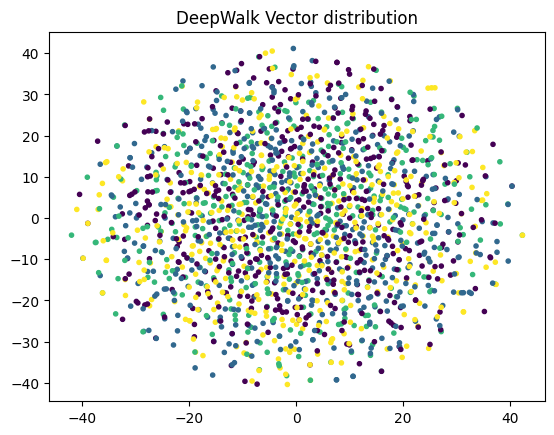

In [52]:
# model = gensim.models.KeyedVectors.load_word2vec_format('Vectorfile/'+method2+'/'+database+'.embeddings')
# data = get_data(database)

# # reduce dimensions to 2
# tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
# result = tsne.fit_transform(np.array(data.vector.tolist()))

# plot_nodes(data.copy(), method2)

# 分类评估

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# 加载数据集
def load_data(data,a):
    # 将数据集拆分为训练集和测试集 
    X_train, X_test, y_train, y_test = train_test_split(
    data.vector.tolist(), data.label, test_size=a, random_state=0)
    return X_train, X_test, y_train, y_test

# 使用LogisticRegression评估
def test_LogisticRegression_multiomaial(data,a):
    
    X_train,X_test,y_train,y_test=load_data(data,a) # 产生用于回归问题的数据集
    y_train=y_train.tolist()
    y_test = y_test.tolist()
    # 选择模型
    
    if database == 'dblp' or database == 'Foursquare':
        cls = LogisticRegression(multi_class='multinomial',solver='lbfgs',  max_iter = 3000)
        # 把数据交给模型训练
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_test)
        f1_micro = f1_score(y_test,y_pred,average='micro')
        f1_macro = f1_score(y_test,y_pred,average='macro')
    if database == 'movie':
        #y_train=y_train.tolist()
        #y_test = y_test.tolist()
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        LR = LogisticRegression(solver='liblinear',multi_class='ovr',n_jobs=-1)
        model = OneVsRestClassifier(LR, n_jobs=-1)
        clf = model.fit(X_train, y_train)
        y_pred =  clf.predict(X_test)
        f1_micro = f1_score(y_test,y_pred,average='micro')
        f1_macro = f1_score(y_test,y_pred,average='macro')
    #print('F1:',f1_micro)
    return f1_micro,f1_macro


def get_F1(data):
    a_list = []
    Fmi_list = []
    Fma_list = []
    for a in range(1,10):
        a_list.append(a/10)
        f1_micro,f1_macro = test_LogisticRegression_multiomaial(data,1-a/10) # 调用 test_LinearRegression
        Fmi_list.append(f1_micro)
        Fma_list.append(f1_macro)
    result = pd.DataFrame({'rate':a_list,'F1_micro':Fmi_list,'F1_macro':Fma_list}).sort_values(by = 'rate')
    return result

In [49]:
# test
result  = get_F1(data)
result.to_csv('evaluation/'+method+'_'+ database+'.csv',index = 0)
result

,rate,F1_micro,F1_macro
0,0.1,0.738220,0.735544
1,0.2,0.767016,0.765315
2,0.3,0.750935,0.749395
3,0.4,0.754799,0.753338
4,0.5,0.759162,0.758230
5,0.6,0.750000,0.749472
6,0.7,0.752182,0.752328
7,0.8,0.785340,0.786345
8,0.9,0.795812,0.799109


# K-Means

In [50]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

def get_NMI():
    # Generate sample data
    np.random.seed(0)
    if database == 'dblp' or database =='Foursquare':
        n_clusters = len(data.label.unique())
    elif database == 'movie':
        n_clusters = len(data.label.apply(lambda x: tuple(x)).unique())
    X = data.vector.tolist()
    labels_true = data.label

    k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    k_means.fit(X)
    y_pr = k_means.labels_
    NMI = normalized_mutual_info_score(data.label, y_pr,average_method='arithmetic')
    return NMI


In [51]:
# EVALUATION
methods = ['Metapath2vec','DeepWalk']
database = 'dblp'
for method in methods:
    model = gensim.models.KeyedVectors.load_word2vec_format('Vectorfile/'+method+'/'+database+'.embeddings')
    data = get_data(database)
    result  = get_F1(data)
    result.to_csv('evaluation/'+method+'_'+ database+'.csv',index = 0)
    print(method,get_NMI())

Metapath2vec 0.2264036595108076
DeepWalk 0.0014880644656254589
